# CS Capstone Project — Linear Regression Modeling of Time Series Logs using both IBS SOH and Calculated SOH1

**Author:** Jason Waterman  
**Course:** UC Berkeley AI/ML Professional Certificate  
**Created:** 2025-10-19  
**Last Updated:** 2025-10-29  
**Version:** 0.1.0  

---

## 📖 Description
This notebook reads a subset of cleaned network data logs with IBS only features, builds a multi-model LR pipeline, compares predicted output vs actual, and does this for both targets - IBS SOH and calculated SOH1. 

Selected IBS only data files for LR model training:
- "12V Management  Discharge and Charge Cycle 2025-06-29_08-10-35_IBS_only.csv"
- "12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv"
- "12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv"
- "12V_Management_2025-06-26_13-39-25_IBS_only.csv"
- "12V Management  IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv"
- "IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv"


### 🔑 Objectives
- Load in a predetermined subset of network data logs with IBS only features
- Trains a multi-model LR pipeline using cross validation and hyperparameters
- Peforms supervised learning on both targets - IBS SOH and calculated SOH1


### 💡 Insights
- Jun 26 (log id: 2025-06-26_13-39-25): captures the initial battery SOH at a steady state of 66% 
- Jun 29 (log id: 06-29_08-10-35): there was a slight fluctuation of battery SOH during its only full charge/discharge cycle from 66->64->68% 
- Jun 29 (log id: 2025-06-29_09-32-11): captures the battery SOH after manual reset of IBS sensor at a steady state of 100% 
- Aug 10 (log id: 00003): captures the battery SOH 6 weeks after IBS was reset at steady state of 90%
- Aug 20 (log id: 2025-08-20_22-17-18_L001): under heavy vehicle loading conditions we manage to capture the battery SOH transitioning from 90% to 80% 
- Oct 04 (log id: 2025-10-04_13-33-54_L006): captures the final battery SOH 6 weeks after sitting again at final steady state of 66% (original ground truth)

## 1. Setup, imports, config

In [1]:
# Import all necessary libraries 
import os
import logging
from pathlib import Path
from IPython.display import Markdown, display
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.exceptions import ConvergenceWarning

# Load project utilities contained in /src
from cs_soh_utils import calculate_soh1, detect_cycles_from_voltage, count_cycles_voltage, merge_short_gaps, parse_log_date, compute_log_soh, attach_soh1_series, ensure_time_index_1s

warnings.filterwarnings("ignore")

CLEANED_CSV_DIR = Path("can_data/cleaned") 

# ---- Choose EXACT files to run  ----
CLEANED_FILENAMES = [
    "12V Management  Discharge and Charge Cycle 2025-06-29_08-10-35_IBS_only.csv",
    "12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv",
    "12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv",
    "12V_Management_2025-06-26_13-39-25_IBS_only.csv",
    "12V Management  IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv",
    "IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv"

]
N_CLEANED = 0  # set to len(CLEANED_FILENAMES); if 0, we’ll set it automatically below

IBS_FEATURES = [
    "IBS_BatteryVoltage",
    "IBS_BatteryCurrent",
    "IBS_BatteryTemperature",
    "IBS_StateOfCharge", 
    "IBS_AvgRi",
    "IBS_NominalCapacity",
    "IBS_AvailableCapacity",
    "IBS_DischargeableAh"
]

warnings.filterwarnings("ignore", category=ConvergenceWarning)

## 2. Build helper functions
- Load in a single clean IBS data log from csv
- Plot folds and stitch together into one

In [2]:
def load_cleaned_csv(path: Path) -> pd.DataFrame:
    """Read a cleaned CSV and try to set a datetime index if present."""
    df = pd.read_csv(path)
    df = ensure_time_index_1s(df)  # normalize time index & 1 s cadence

    # Try common time columns
    time_col = None
    for c in ["time", "timestamp", "time_utc", "DateTime"]:
        if c in df.columns:
            time_col = c
            break

    if time_col is not None:
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce", utc=True)
        df = df.set_index(time_col).sort_index()
    else:
        # If no time column, leave index as-is
        pass

    return df


def plot_all_folds_overlay(y_full, y_pred_full, test_spans, title="Actual vs Predicted across all folds"):
    fig, ax = plt.subplots(figsize=(14,5))

    # Light downsampling of the full series for readability
    step = max(1, len(y_full)//2000)

    # Actual: full
    ax.plot(y_full.index[::step], y_full.iloc[::step], label="Actual", linewidth=2)

    # Predicted: only where test predictions exist
    mask = y_pred_full.notna()
    ax.plot(y_full.index[mask][::step], y_pred_full[mask][::step],
            linestyle="--", linewidth=2, label="Predicted (CV test)")

    # Fold shading + labels
    for i, (ts, te) in enumerate(test_spans, start=1):
        ax.axvline(ts, color="k", linestyle=":", linewidth=1)
        ax.axvline(te, color="k", linestyle=":", linewidth=1)
        ax.axvspan(ts, te, alpha=0.06)
        mid = ts + (te - ts)/2
        ax.annotate(f"Fold {i}", xy=(mid, 1), xycoords=('data','axes fraction'),
                    xytext=(0,3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

    # Focus on the tested region
    if test_spans:
        ax.set_xlim(test_spans[0][0], test_spans[-1][1])

    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))
    fig.autofmt_xdate()

    fig.suptitle(title, y=1.06, fontsize=14)
    fig.tight_layout(rect=[0,0,1,0.97])

    ax.set_xlabel("Time")
    ax.set_ylabel(y_full.name or "Target")
    ax.legend()
    ax.ticklabel_format(axis="y", useOffset=False)
    plt.show()

    return fig

## 3. Build Multi-model Linear Regression Pipeline w/ cross validation hyperparameters
- Polynomial features
- Scaling
- Linear Regression, Ridge, and Lasso

In [3]:
# Build a grid search pipeline that uses a scaled linear regression model with tunable polynomial degree and inner fold splits
def build_pipeline():
    
    pipe = Pipeline ([
        ("poly", PolynomialFeatures(include_bias=False)),
        ("scale", StandardScaler()),
        ("reg", LinearRegression())
    ])

    # Define hyperparameters for LR - degree + intercept
    param_grid = [
        {
            "poly__degree":[1, 2, 3], 
            "reg__fit_intercept":[True, False]
        },
        {
            "reg": [Ridge(max_iter=10000, random_state=0)],
            "poly__degree": [1, 2, 3],
            "reg__alpha": [1e-3, 1e-2, 1e-1, 1, 10]

        },
        {
            "reg": [Lasso(max_iter=10000, random_state=0)],
            "poly__degree": [1, 2, 3],
            "reg__alpha": [1e-3, 1e-2, 1e-1, 1, 10],

        },
    ]

    inner_cv = TimeSeriesSplit(n_splits=3)

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=inner_cv,
        refit=True,
        n_jobs=-1,
        return_train_score=True
    )
    return grid



## 4. Main Loop - Train Multi-Model Linear Regression CV pipeline on DATA LOGS for each TARGET (SOH and SOH1)
- Load a cleand csv data log
- Calculate SOH1
- Split data using time series split with multiple folds 
- Execute model regression pipeline on each fold for each target (SOH and SOH1)
- Plot actual vs predicted each target (SOH and SOH1)
- Calculate error metrics for each fold and print error metric table

### Train multi-model regression pipeline for: 
- 12V Management  Discharge and Charge Cycle 2025-06-29_08-10-35_IBS_only.csv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toler

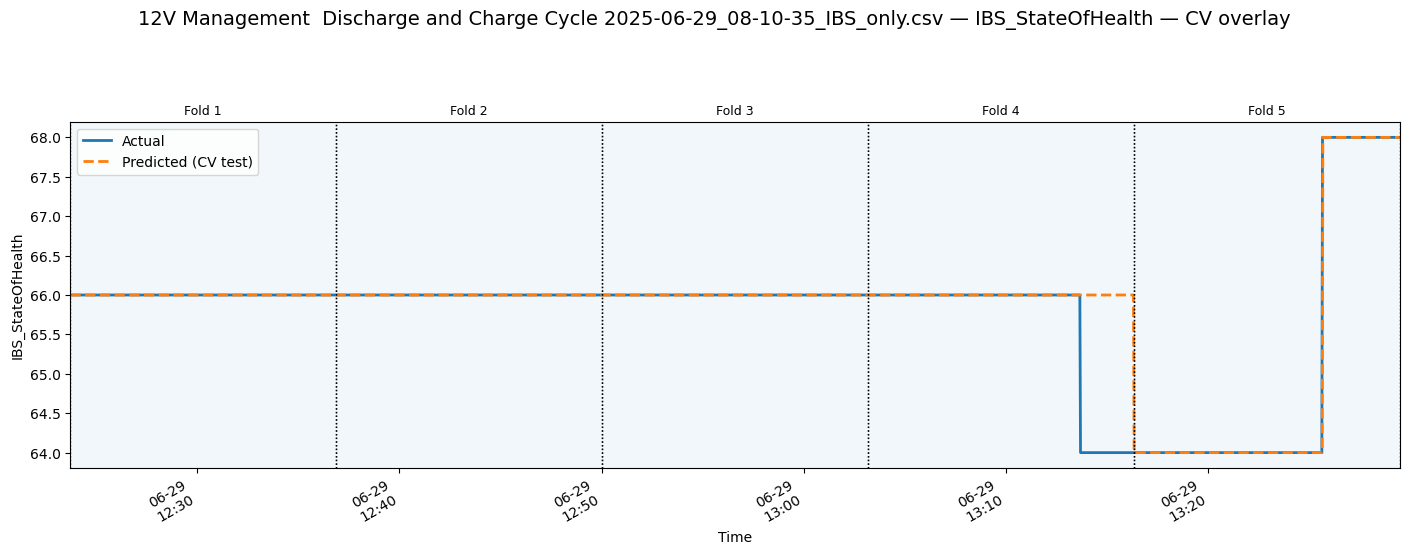

NameError: name 'used_feats' is not defined

In [4]:
all_fold_tables = []   

path = CLEANED_CSV_DIR / "12V Management  Discharge and Charge Cycle 2025-06-29_08-10-35_IBS_only.csv"

# Load in cleaned CSV Log File
df = load_cleaned_csv(path)

targets = ["IBS_StateOfHealth", "SOH1"]   # Pass 1 and Pass 2

for target_col in targets:

    # Set features to IBS_FEATURES
    X = df[IBS_FEATURES]    

    # Assign y to either IBS_StateOfHealth or cacluclate SOH1
    if target_col == 'SOH1':
        y = calculate_soh1(df,return_components=True, return_series=True, resample_s=1, return_vendor=False)
        y = y['SOH1']
    else: 
        y = df["IBS_StateOfHealth"]

    # Utilize time series split to divide up dataframe into both train and test while preserving chronology of the data
    tscv = TimeSeriesSplit(n_splits=5)
    splits = list(tscv.split(X, y))

    y_pred_full = pd.Series(index=y.index, dtype=float)
    
    fold_metrics = []
    test_spans = []

    for fold, (train_idx, test_idx) in enumerate(splits, start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        lr_grid_model = build_pipeline().fit(X_train, y_train)      
        y_pred = lr_grid_model.predict(X_test)

        # track each fold's test span for overlay plot
        ts = y.index[test_idx[0]]
        te = y.index[test_idx[-1]]
        test_spans.append((ts, te))

        # Keep track of best model for this fold
        best_model = lr_grid_model.best_estimator_
        y_pred = best_model.predict(X_test)

        # Keep track of test predictions aligned to the original time series data
        y_pred_full.iloc[test_idx] = y_pred

        # Keep track of metrics per fold
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2   = r2_score(y_test, y_pred)
        fold_metrics.append({"fold": fold, "best_model": best_model,"rmse": rmse, "r2": r2, "best_params": lr_grid_model.best_params_})
        
    # Single overlay plot: Actual (full) vs Predicted (test only) with fold indicators
    plot_all_folds_overlay(y, y_pred_full, test_spans, title=f"{path.name} — {target_col} — CV overlay")

    # show per-fold metrics table for this file+target
    fold_df = pd.DataFrame(fold_metrics)
    fold_df["file"] = path.name
    fold_df["target"] = target_col
    fold_df["features"] = ", ".join(used_feats)
    display(fold_df.style.format({"rmse":"{:.4f}", "r2":"{:.3f}"}))
    all_fold_tables.append(fold_df)

    

### Train multi-model regression pipeline for: 
- 12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toler

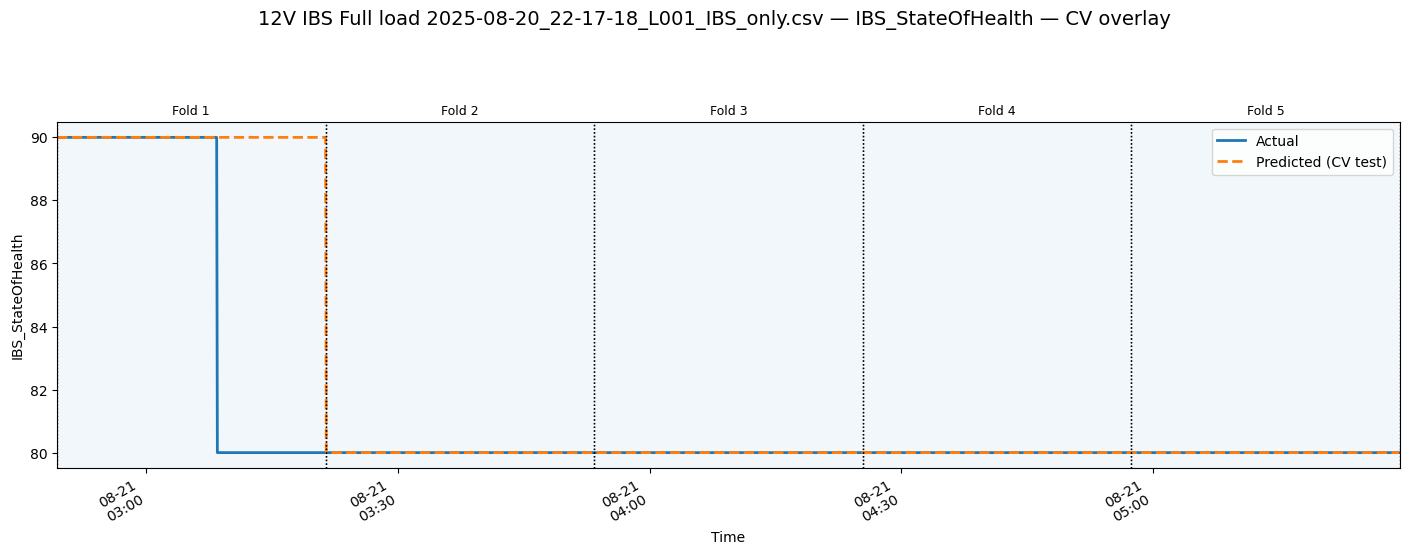

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",6.3598,-0.679,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,0.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,0.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,0.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,0.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


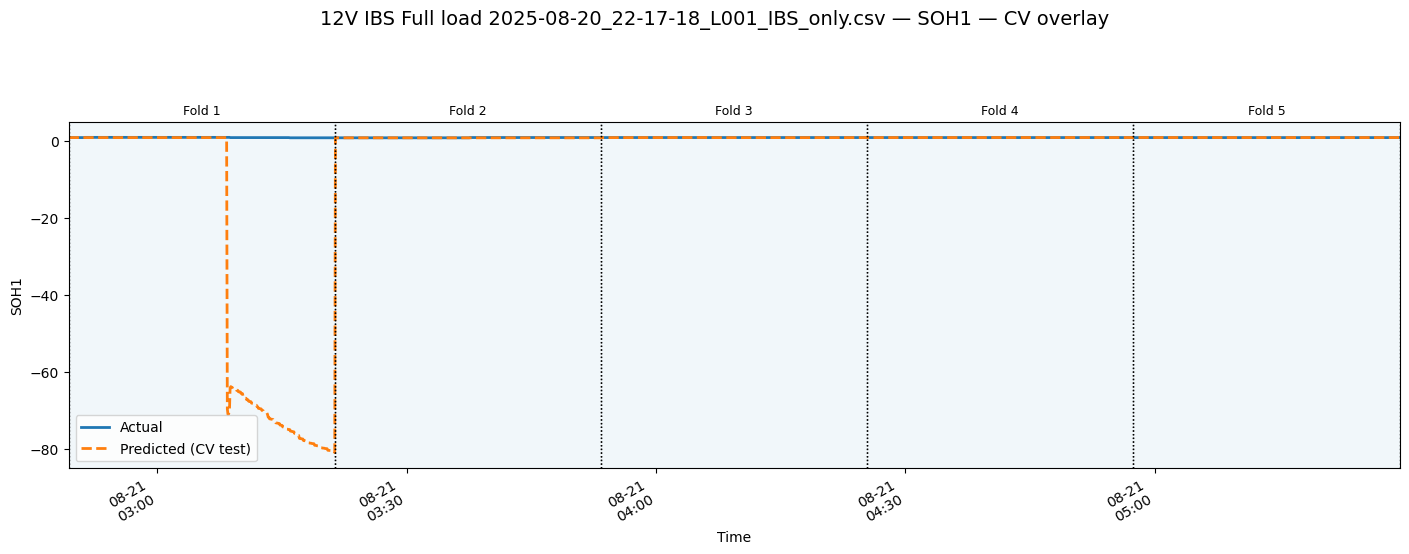

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",47.3397,-1230129.619,"{'poly__degree': 3, 'reg__fit_intercept': True}",12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)), ('scale', StandardScaler()), ('reg', Ridge(alpha=10, max_iter=10000, random_state=0))])",0.0537,-1.187,"{'poly__degree': 2, 'reg': Ridge(max_iter=10000, random_state=0), 'reg__alpha': 10, 'reg__max_iter': 10000}",12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', Lasso(alpha=0.01, max_iter=10000, random_state=0))])",0.0166,-1.381,"{'poly__degree': 1, 'reg': Lasso(max_iter=10000, random_state=0), 'reg__alpha': 0.01, 'reg__max_iter': 10000}",12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)), ('scale', StandardScaler()), ('reg', Lasso(alpha=0.01, max_iter=10000, random_state=0))])",0.0022,0.852,"{'poly__degree': 3, 'reg': Lasso(max_iter=10000, random_state=0), 'reg__alpha': 0.01, 'reg__max_iter': 10000}",12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', Lasso(alpha=0.1, max_iter=10000, random_state=0))])",0.0085,-0.542,"{'poly__degree': 1, 'reg': Lasso(max_iter=10000, random_state=0), 'reg__alpha': 0.1, 'reg__max_iter': 10000}",12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


In [ ]:
all_fold_tables = []   

path = CLEANED_CSV_DIR / "12V IBS Full load 2025-08-20_22-17-18_L001_IBS_only.csv"

# Load in cleaned CSV Log File
df = load_cleaned_csv(path)

targets = ["IBS_StateOfHealth", "SOH1"]   # Pass 1 and Pass 2

for target_col in targets:

    # Set features to IBS_FEATURES
    X = df[IBS_FEATURES]    

    # Assign y to either IBS_StateOfHealth or cacluclate SOH1
    if target_col == 'SOH1':
        y = calculate_soh1(df,return_components=True, return_series=True, resample_s=1, return_vendor=False)
        y = y['SOH1']
    else: 
        y = df["IBS_StateOfHealth"]

    # Utilize time series split to divide up dataframe into both train and test while preserving chronology of the data
    tscv = TimeSeriesSplit(n_splits=5)
    splits = list(tscv.split(X, y))

    y_pred_full = pd.Series(index=y.index, dtype=float)
    
    fold_metrics = []
    test_spans = []

    for fold, (train_idx, test_idx) in enumerate(splits, start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        lr_grid_model = build_pipeline().fit(X_train, y_train)      
        y_pred = lr_grid_model.predict(X_test)

        # track each fold's test span for overlay plot
        ts = y.index[test_idx[0]]
        te = y.index[test_idx[-1]]
        test_spans.append((ts, te))

        # Keep track of best model for this fold
        best_model = lr_grid_model.best_estimator_
        y_pred = best_model.predict(X_test)

        # Keep track of test predictions aligned to the original time series data
        y_pred_full.iloc[test_idx] = y_pred

        # Keep track of metrics per fold
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2   = r2_score(y_test, y_pred)
        fold_metrics.append({"fold": fold, "best_model": best_model,"rmse": rmse, "r2": r2, "best_params": lr_grid_model.best_params_})
        
    # Single overlay plot: Actual (full) vs Predicted (test only) with fold indicators
    plot_all_folds_overlay(y, y_pred_full, test_spans, title=f"{path.name} — {target_col} — CV overlay")

    # show per-fold metrics table for this file+target
    fold_df = pd.DataFrame(fold_metrics)
    fold_df["file"] = path.name
    fold_df["target"] = target_col
    fold_df["features"] = ", ".join(used_feats)
    display(fold_df.style.format({"rmse":"{:.4f}", "r2":"{:.3f}"}))
    all_fold_tables.append(fold_df)

    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toler

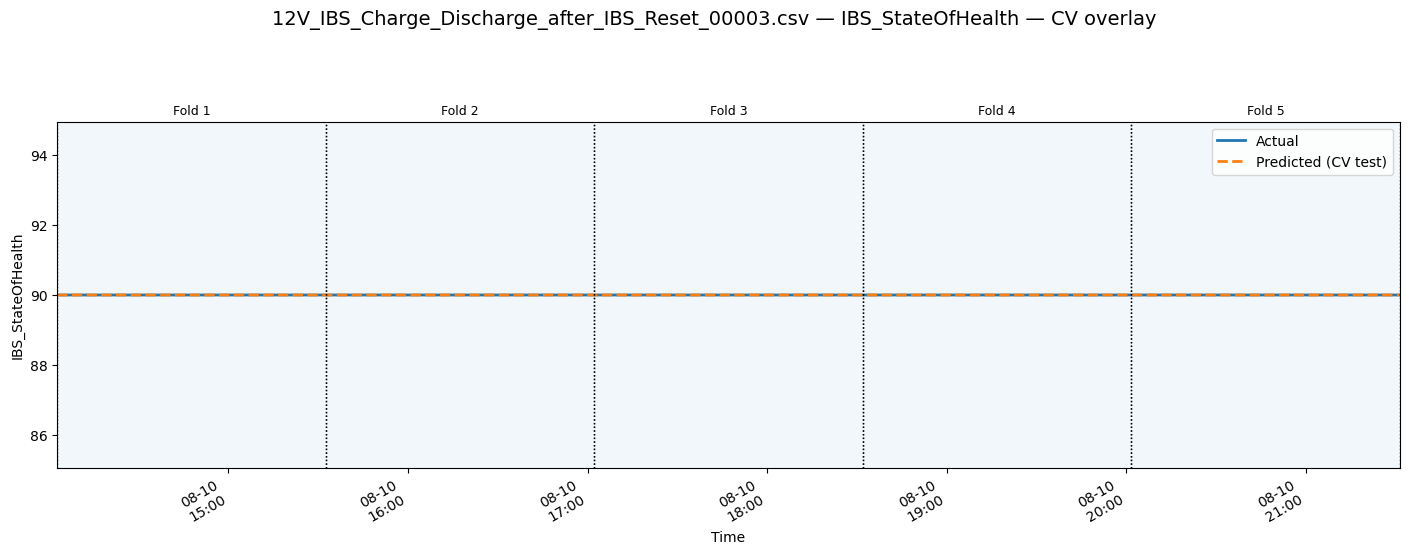

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


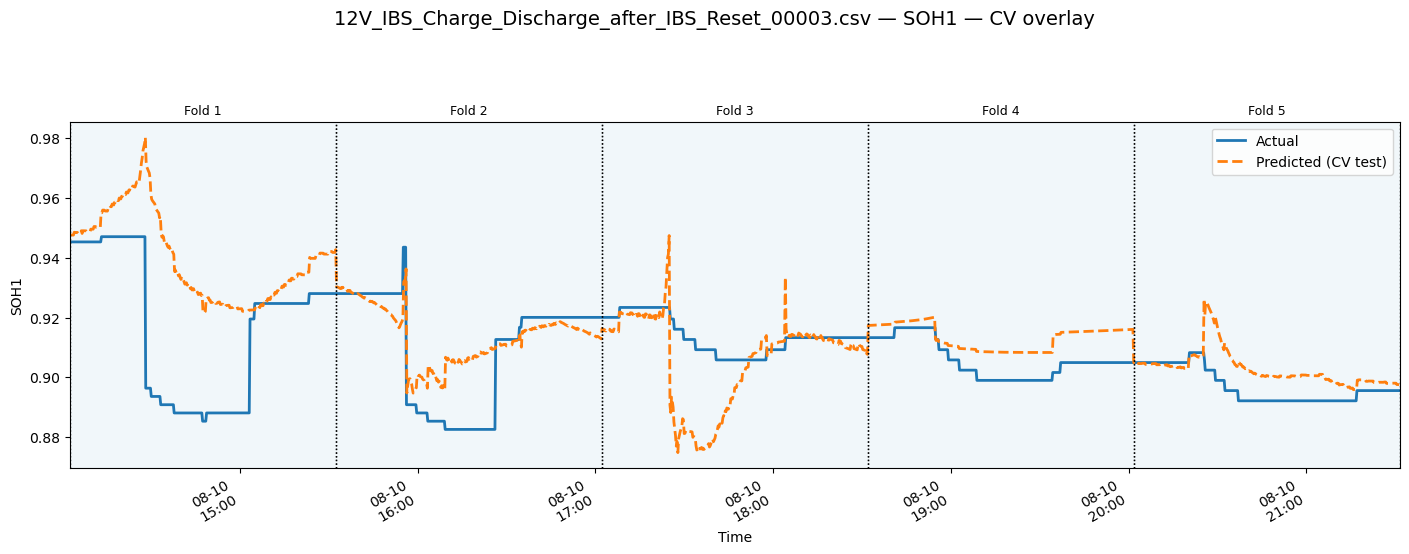

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression(fit_intercept=False))])",0.0299,-0.564,"{'poly__degree': 1, 'reg__fit_intercept': False}",12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)), ('scale', StandardScaler()), ('reg', Ridge(alpha=0.1, max_iter=10000, random_state=0))])",0.0121,0.573,"{'poly__degree': 3, 'reg': Ridge(max_iter=10000, random_state=0), 'reg__alpha': 0.1, 'reg__max_iter': 10000}",12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)), ('scale', StandardScaler()), ('reg', Ridge(alpha=0.001, max_iter=10000, random_state=0))])",0.0149,-5.133,"{'poly__degree': 3, 'reg': Ridge(max_iter=10000, random_state=0), 'reg__alpha': 0.001, 'reg__max_iter': 10000}",12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)), ('scale', StandardScaler()), ('reg', Lasso(alpha=0.01, max_iter=10000, random_state=0))])",0.0083,-0.742,"{'poly__degree': 2, 'reg': Lasso(max_iter=10000, random_state=0), 'reg__alpha': 0.01, 'reg__max_iter': 10000}",12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)), ('scale', StandardScaler()), ('reg', Ridge(alpha=10, max_iter=10000, random_state=0))])",0.0079,-0.915,"{'poly__degree': 2, 'reg': Ridge(max_iter=10000, random_state=0), 'reg__alpha': 10, 'reg__max_iter': 10000}",12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


In [ ]:
path = CLEANED_CSV_DIR / "12V_IBS_Charge_Discharge_after_IBS_Reset_00003.csv"

all_fold_tables = []  

# Load in cleaned CSV Log File
df = load_cleaned_csv(path)

targets = ["IBS_StateOfHealth", "SOH1"]   # Pass 1 and Pass 2

for target_col in targets:

    # Set features to IBS_FEATURES
    X = df[IBS_FEATURES]    

    # Assign y to either IBS_StateOfHealth or cacluclate SOH1
    if target_col == 'SOH1':
        y = calculate_soh1(df,return_components=True, return_series=True, resample_s=1, return_vendor=False)
        y = y['SOH1']
    else: 
        y = df["IBS_StateOfHealth"]

    # Utilize time series split to divide up dataframe into both train and test while preserving chronology of the data
    tscv = TimeSeriesSplit(n_splits=5)
    splits = list(tscv.split(X, y))

    y_pred_full = pd.Series(index=y.index, dtype=float)
    
    fold_metrics = []
    test_spans = []

    for fold, (train_idx, test_idx) in enumerate(splits, start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        lr_grid_model = build_pipeline().fit(X_train, y_train)      
        y_pred = lr_grid_model.predict(X_test)

        # track each fold's test span for overlay plot
        ts = y.index[test_idx[0]]
        te = y.index[test_idx[-1]]
        test_spans.append((ts, te))

        # Keep track of best model for this fold
        best_model = lr_grid_model.best_estimator_
        y_pred = best_model.predict(X_test)

        # Keep track of test predictions aligned to the original time series data
        y_pred_full.iloc[test_idx] = y_pred

        # Keep track of metrics per fold
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2   = r2_score(y_test, y_pred)
        fold_metrics.append({"fold": fold, "best_model": best_model,"rmse": rmse, "r2": r2, "best_params": lr_grid_model.best_params_})
        
    # Single overlay plot: Actual (full) vs Predicted (test only) with fold indicators
    plot_all_folds_overlay(y, y_pred_full, test_spans, title=f"{path.name} — {target_col} — CV overlay")

    # show per-fold metrics table for this file+target
    fold_df = pd.DataFrame(fold_metrics)
    fold_df["file"] = path.name
    fold_df["target"] = target_col
    fold_df["features"] = ", ".join(used_feats)
    display(fold_df.style.format({"rmse":"{:.4f}", "r2":"{:.3f}"}))
    all_fold_tables.append(fold_df)

    

### Train multi-model regression pipeline for: 
"12V Management  2025-06-25_22-20-47_IBS_only.csv"
- Log contains sleep time periods. Running load_cleaned_csv will perform 1s resampling and insert NaNs for missing data while sleeping. Therefore, for these data logs need to make sure data is sampled at 1s and just use pd.read_csv function.

(4306, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4306 entries, 0 to 4305
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   time_utc                4306 non-null   object 
 1   VCU_ChrgSysOperCmd      4306 non-null   float64
 2   IBS_BatteryDefect       4306 non-null   float64
 3   IBS_Sulfation           4306 non-null   float64
 4   IBS_EngineStart         4306 non-null   float64
 5   IBS_PowerOn             4306 non-null   float64
 6   IBS_LowVoltage          4306 non-null   float64
 7   IBS_WakeupStatus        4306 non-null   float64
 8   IBS_SOCUpperTolerance   4306 non-null   float64
 9   IBS_SOCLowerTolerance   4306 non-null   float64
 10  IBS_CapacityLossTop     4306 non-null   float64
 11  IBS_CapacityLossBottom  4306 non-null   float64
 12  IBS_BatteryCurrent      4306 non-null   float64
 13  IBS_BatteryVoltage      4306 non-null   float64
 14  IBS_BatteryTemperature  4306 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toler

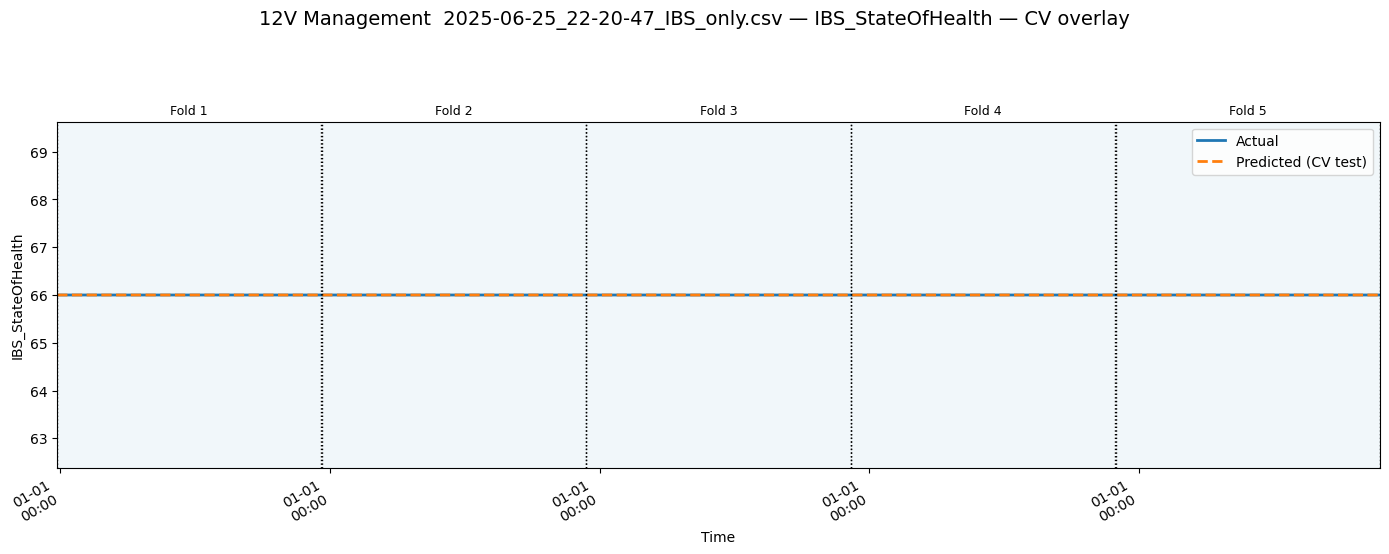

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management 2025-06-25_22-20-47_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management 2025-06-25_22-20-47_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management 2025-06-25_22-20-47_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management 2025-06-25_22-20-47_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management 2025-06-25_22-20-47_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toler

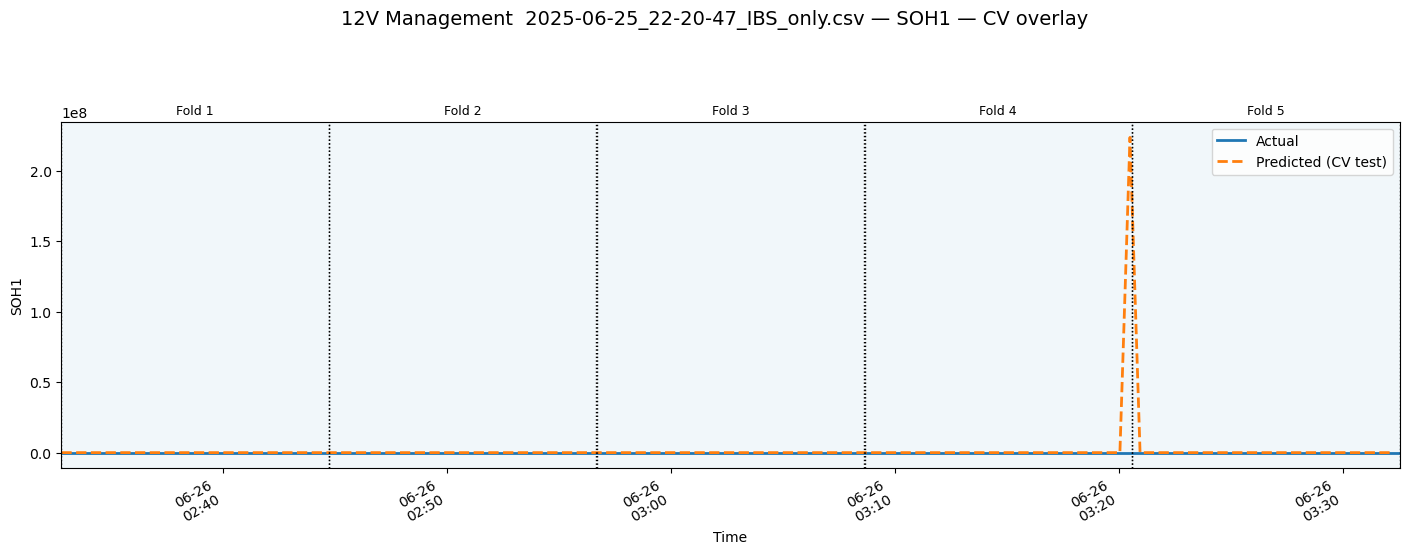

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.1703,-0.422,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management 2025-06-25_22-20-47_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0810,-3.789,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management 2025-06-25_22-20-47_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)), ('scale', StandardScaler()), ('reg', Ridge(alpha=0.001, max_iter=10000, random_state=0))])",0.0772,-0.222,"{'poly__degree': 3, 'reg': Ridge(max_iter=10000, random_state=0), 'reg__alpha': 0.001, 'reg__max_iter': 10000}",12V Management 2025-06-25_22-20-47_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",30111876.8361,-46408527088986669056.000,"{'poly__degree': 2, 'reg__fit_intercept': True}",12V Management 2025-06-25_22-20-47_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)), ('scale', StandardScaler()), ('reg', Ridge(alpha=10, max_iter=10000, random_state=0))])",0.0994,-200408366334077483037440868352.000,"{'poly__degree': 3, 'reg': Ridge(max_iter=10000, random_state=0), 'reg__alpha': 10, 'reg__max_iter': 10000}",12V Management 2025-06-25_22-20-47_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


In [ ]:
path = CLEANED_CSV_DIR / "12V Management  2025-06-25_22-20-47_IBS_only.csv"

all_fold_tables = []  

# Load in cleaned CSV Log File
#df = load_cleaned_csv(path)
df = pd.read_csv(path)
print(df.shape)
print(df.info())

targets = ["IBS_StateOfHealth", "SOH1"]   # Pass 1 and Pass 2

for target_col in targets:

    # Set features to IBS_FEATURES
    X = df[IBS_FEATURES]    

    # Assign y to either IBS_StateOfHealth or cacluclate SOH1
    if target_col == 'SOH1':
        y = calculate_soh1(df,return_components=True, return_series=True, resample_s=1, return_vendor=False)
        y = y['SOH1']
    else: 
        y = df["IBS_StateOfHealth"]

    # Utilize time series split to divide up dataframe into both train and test while preserving chronology of the data
    tscv = TimeSeriesSplit(n_splits=5)
    splits = list(tscv.split(X, y))

    y_pred_full = pd.Series(index=y.index, dtype=float)
    
    fold_metrics = []
    test_spans = []

    for fold, (train_idx, test_idx) in enumerate(splits, start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        lr_grid_model = build_pipeline().fit(X_train, y_train)      
        y_pred = lr_grid_model.predict(X_test)

        # track each fold's test span for overlay plot
        ts = y.index[test_idx[0]]
        te = y.index[test_idx[-1]]
        test_spans.append((ts, te))

        # Keep track of best model for this fold
        best_model = lr_grid_model.best_estimator_
        y_pred = best_model.predict(X_test)

        # Keep track of test predictions aligned to the original time series data
        y_pred_full.iloc[test_idx] = y_pred

        # Keep track of metrics per fold
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2   = r2_score(y_test, y_pred)
        fold_metrics.append({"fold": fold, "best_model": best_model,"rmse": rmse, "r2": r2, "best_params": lr_grid_model.best_params_})
        
    # Single overlay plot: Actual (full) vs Predicted (test only) with fold indicators
    plot_all_folds_overlay(y, y_pred_full, test_spans, title=f"{path.name} — {target_col} — CV overlay")

    # show per-fold metrics table for this file+target
    fold_df = pd.DataFrame(fold_metrics)
    fold_df["file"] = path.name
    fold_df["target"] = target_col
    fold_df["features"] = ", ".join(used_feats)
    display(fold_df.style.format({"rmse":"{:.4f}", "r2":"{:.3f}"}))
    all_fold_tables.append(fold_df)

    

### Train multi-model regression pipeline for: 
- 12V_Management_2025-06-26_13-39-25_IBS_only.csv
- SOH1 calculates to 0 for this period. Need to find investigate more why?

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toler

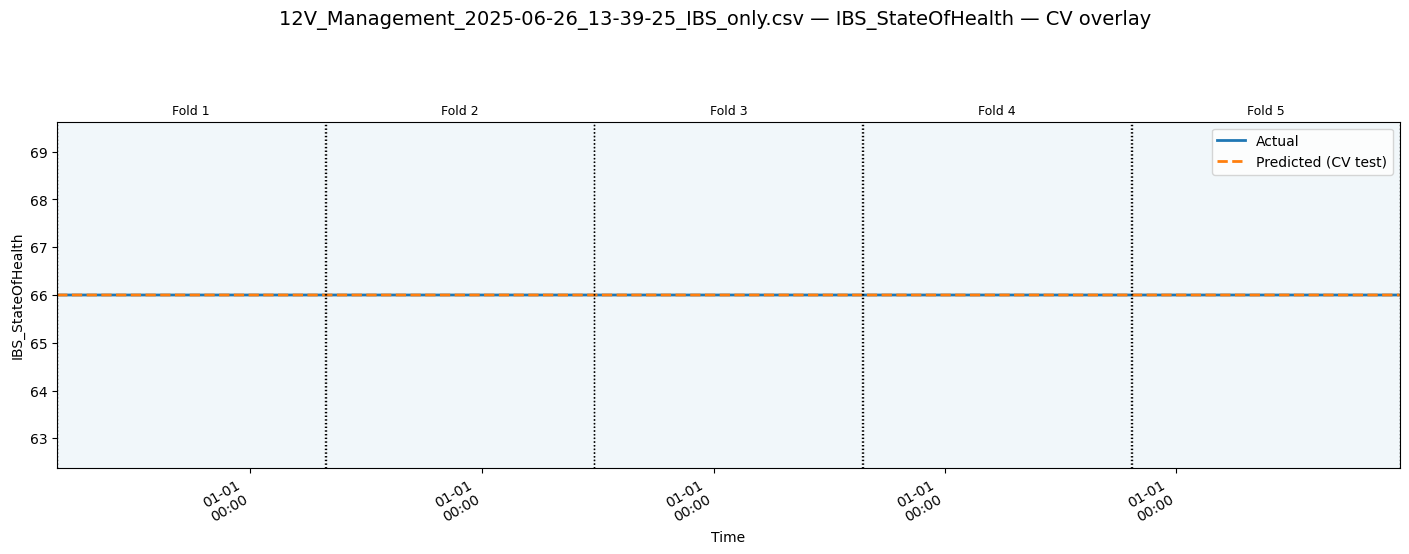

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V_Management_2025-06-26_13-39-25_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V_Management_2025-06-26_13-39-25_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V_Management_2025-06-26_13-39-25_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V_Management_2025-06-26_13-39-25_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V_Management_2025-06-26_13-39-25_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toler

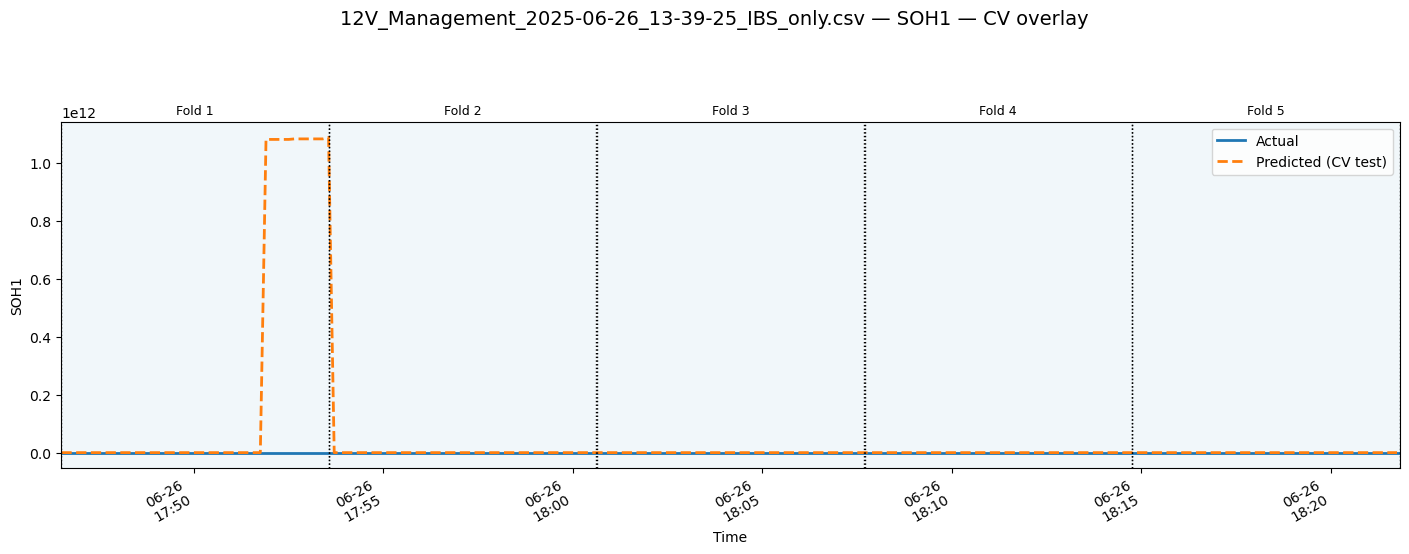

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",525151498568.9021,-35645496615755785013559296.000,"{'poly__degree': 2, 'reg__fit_intercept': True}",12V_Management_2025-06-26_13-39-25_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', Lasso(alpha=0.01, max_iter=10000, random_state=0))])",0.0975,-1970.502,"{'poly__degree': 1, 'reg': Lasso(max_iter=10000, random_state=0), 'reg__alpha': 0.01, 'reg__max_iter': 10000}",12V_Management_2025-06-26_13-39-25_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', Lasso(alpha=0.1, max_iter=10000, random_state=0))])",0.0299,-1559.323,"{'poly__degree': 1, 'reg': Lasso(max_iter=10000, random_state=0), 'reg__alpha': 0.1, 'reg__max_iter': 10000}",12V_Management_2025-06-26_13-39-25_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)), ('scale', StandardScaler()), ('reg', Ridge(alpha=0.1, max_iter=10000, random_state=0))])",0.0062,-3083.471,"{'poly__degree': 3, 'reg': Ridge(max_iter=10000, random_state=0), 'reg__alpha': 0.1, 'reg__max_iter': 10000}",12V_Management_2025-06-26_13-39-25_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)), ('scale', StandardScaler()), ('reg', Ridge(alpha=0.1, max_iter=10000, random_state=0))])",0.1503,-5193.007,"{'poly__degree': 3, 'reg': Ridge(max_iter=10000, random_state=0), 'reg__alpha': 0.1, 'reg__max_iter': 10000}",12V_Management_2025-06-26_13-39-25_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


In [ ]:
path = CLEANED_CSV_DIR / "12V_Management_2025-06-26_13-39-25_IBS_only.csv"

all_fold_tables = []  

# Load in cleaned CSV Log File
#df = load_cleaned_csv(path)
df = pd.read_csv(path)

targets = ["IBS_StateOfHealth", "SOH1"]   # Pass 1 and Pass 2

for target_col in targets:

    # Set features to IBS_FEATURES
    X = df[IBS_FEATURES]    

    # Assign y to either IBS_StateOfHealth or cacluclate SOH1
    if target_col == 'SOH1':
        y = calculate_soh1(df,return_components=True, return_series=True, resample_s=1, return_vendor=False)
        y = y['SOH1']
    else: 
        y = df["IBS_StateOfHealth"]

    # Utilize time series split to divide up dataframe into both train and test while preserving chronology of the data
    tscv = TimeSeriesSplit(n_splits=5)
    splits = list(tscv.split(X, y))

    y_pred_full = pd.Series(index=y.index, dtype=float)
    
    fold_metrics = []
    test_spans = []

    for fold, (train_idx, test_idx) in enumerate(splits, start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        lr_grid_model = build_pipeline().fit(X_train, y_train)      
        y_pred = lr_grid_model.predict(X_test)

        # track each fold's test span for overlay plot
        ts = y.index[test_idx[0]]
        te = y.index[test_idx[-1]]
        test_spans.append((ts, te))

        # Keep track of best model for this fold
        best_model = lr_grid_model.best_estimator_
        y_pred = best_model.predict(X_test)

        # Keep track of test predictions aligned to the original time series data
        y_pred_full.iloc[test_idx] = y_pred

        # Keep track of metrics per fold
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2   = r2_score(y_test, y_pred)
        fold_metrics.append({"fold": fold, "best_model": best_model,"rmse": rmse, "r2": r2, "best_params": lr_grid_model.best_params_})
        
    # Single overlay plot: Actual (full) vs Predicted (test only) with fold indicators
    plot_all_folds_overlay(y, y_pred_full, test_spans, title=f"{path.name} — {target_col} — CV overlay")

    # show per-fold metrics table for this file+target
    fold_df = pd.DataFrame(fold_metrics)
    fold_df["file"] = path.name
    fold_df["target"] = target_col
    fold_df["features"] = ", ".join(used_feats)
    display(fold_df.style.format({"rmse":"{:.4f}", "r2":"{:.3f}"}))
    all_fold_tables.append(fold_df)

    

(714, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   time_utc                714 non-null    object 
 1   VCU_ChrgSysOperCmd      714 non-null    int64  
 2   IBS_BatteryDefect       714 non-null    int64  
 3   IBS_Sulfation           714 non-null    int64  
 4   IBS_EngineStart         714 non-null    int64  
 5   IBS_PowerOn             714 non-null    int64  
 6   IBS_LowVoltage          714 non-null    int64  
 7   IBS_WakeupStatus        714 non-null    int64  
 8   IBS_SOCUpperTolerance   714 non-null    int64  
 9   IBS_SOCLowerTolerance   714 non-null    int64  
 10  IBS_CapacityLossTop     714 non-null    int64  
 11  IBS_CapacityLossBottom  714 non-null    int64  
 12  IBS_BatteryCurrent      714 non-null    float64
 13  IBS_BatteryVoltage      714 non-null    float64
 14  IBS_BatteryTemperature  714 non-

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toler

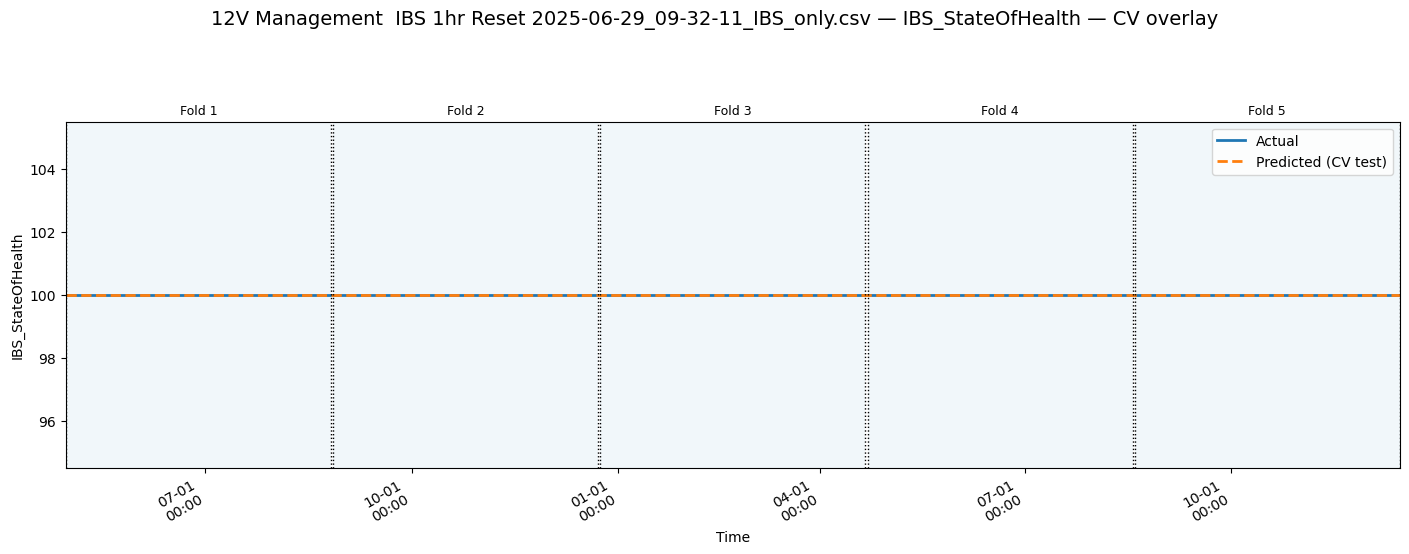

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toler

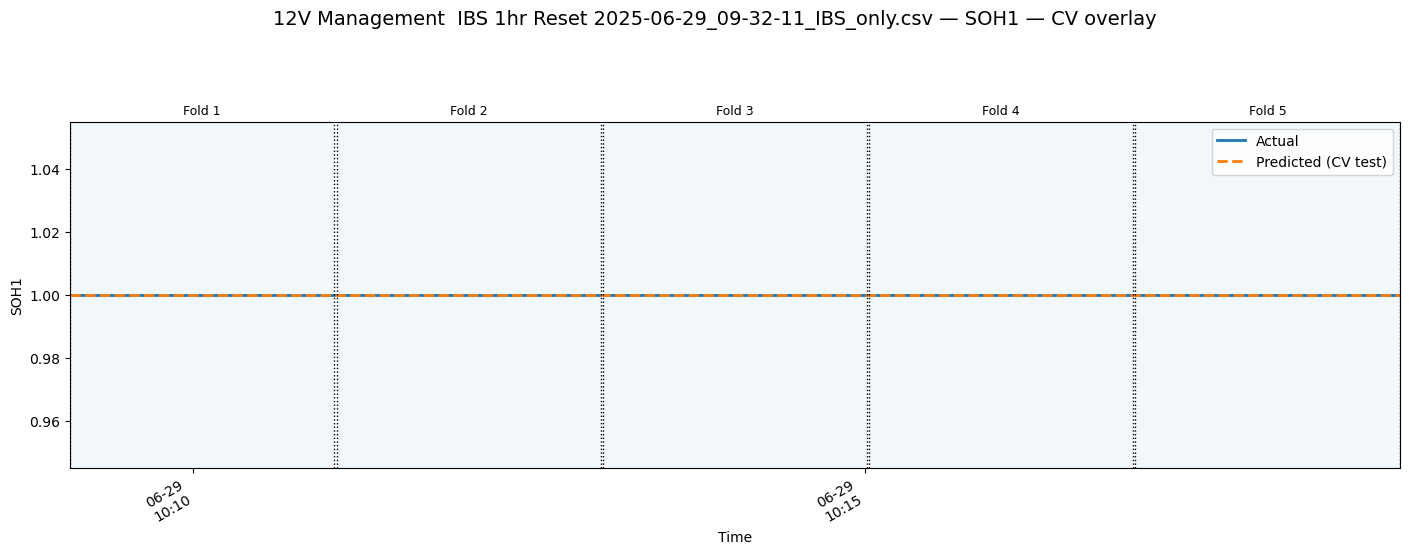

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",12V Management IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


In [ ]:
path = CLEANED_CSV_DIR / "12V Management  IBS 1hr Reset 2025-06-29_09-32-11_IBS_only.csv"

all_fold_tables = []  

# Load in cleaned CSV Log File
#df = load_cleaned_csv(path)
df = pd.read_csv(path)          # Simple read. Do not resample as vehicle has sleep modes
df = pd.read_csv(path)
print(df.shape)
print(df.info())

targets = ["IBS_StateOfHealth", "SOH1"]   # Pass 1 and Pass 2

for target_col in targets:

    # Set features to IBS_FEATURES
    X = df[IBS_FEATURES]    

    # Assign y to either IBS_StateOfHealth or cacluclate SOH1
    if target_col == 'SOH1':
        y = calculate_soh1(df,return_components=True, return_series=True, resample_s=1, return_vendor=False)
        y = y['SOH1']
    else: 
        y = df["IBS_StateOfHealth"]

    # Utilize time series split to divide up dataframe into both train and test while preserving chronology of the data
    tscv = TimeSeriesSplit(n_splits=5)
    splits = list(tscv.split(X, y))

    y_pred_full = pd.Series(index=y.index, dtype=float)
    
    fold_metrics = []
    test_spans = []

    for fold, (train_idx, test_idx) in enumerate(splits, start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        lr_grid_model = build_pipeline().fit(X_train, y_train)      
        y_pred = lr_grid_model.predict(X_test)

        # track each fold's test span for overlay plot
        ts = y.index[test_idx[0]]
        te = y.index[test_idx[-1]]
        test_spans.append((ts, te))

        # Keep track of best model for this fold
        best_model = lr_grid_model.best_estimator_
        y_pred = best_model.predict(X_test)

        # Keep track of test predictions aligned to the original time series data
        y_pred_full.iloc[test_idx] = y_pred

        # Keep track of metrics per fold
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2   = r2_score(y_test, y_pred)
        fold_metrics.append({"fold": fold, "best_model": best_model,"rmse": rmse, "r2": r2, "best_params": lr_grid_model.best_params_})
        
    # Single overlay plot: Actual (full) vs Predicted (test only) with fold indicators
    plot_all_folds_overlay(y, y_pred_full, test_spans, title=f"{path.name} — {target_col} — CV overlay")

    # show per-fold metrics table for this file+target
    fold_df = pd.DataFrame(fold_metrics)
    fold_df["file"] = path.name
    fold_df["target"] = target_col
    fold_df["features"] = ", ".join(used_feats)
    display(fold_df.style.format({"rmse":"{:.4f}", "r2":"{:.3f}"}))
    all_fold_tables.append(fold_df)

    

(1235, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   time_utc_iso            1235 non-null   object 
 1   VCU_ChrgSysOperCmd      1235 non-null   int64  
 2   IBS_BatteryDefect       1235 non-null   int64  
 3   IBS_Sulfation           1235 non-null   int64  
 4   IBS_EngineStart         1235 non-null   int64  
 5   IBS_PowerOn             1235 non-null   int64  
 6   IBS_LowVoltage          1235 non-null   int64  
 7   IBS_WakeupStatus        1235 non-null   int64  
 8   IBS_SOCUpperTolerance   1235 non-null   int64  
 9   IBS_SOCLowerTolerance   1235 non-null   int64  
 10  IBS_CapacityLossTop     1235 non-null   int64  
 11  IBS_CapacityLossBottom  1235 non-null   int64  
 12  IBS_BatteryCurrent      1235 non-null   float64
 13  IBS_BatteryVoltage      1235 non-null   float64
 14  IBS_BatteryTemperature  1235 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toler

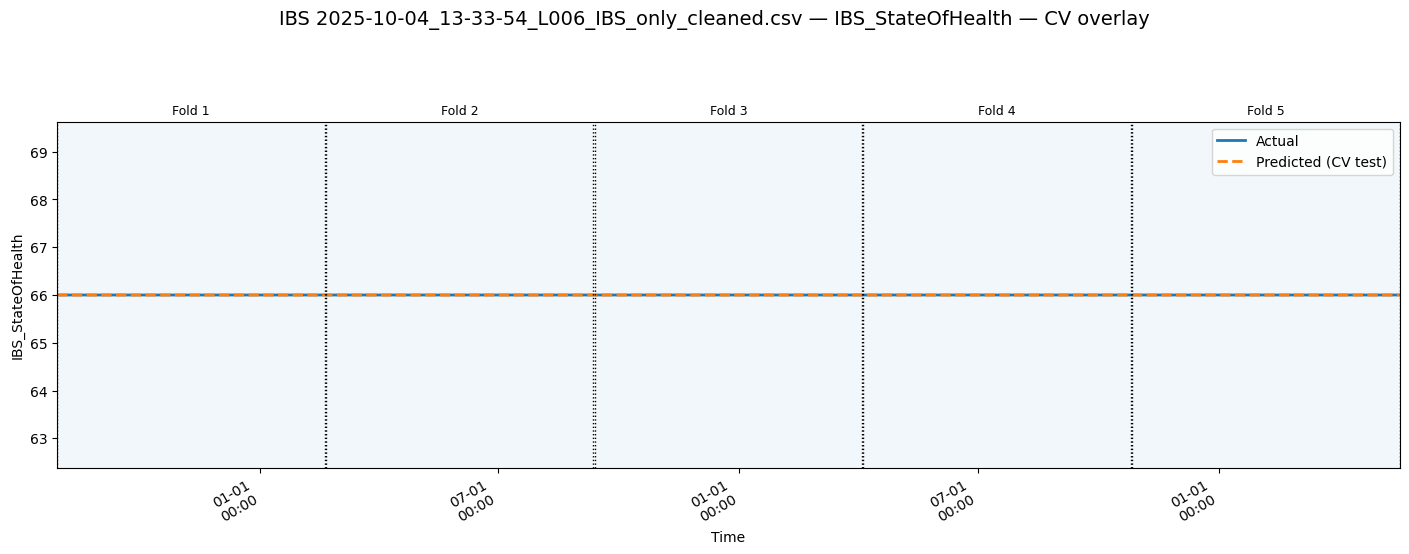

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv,IBS_StateOfHealth,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


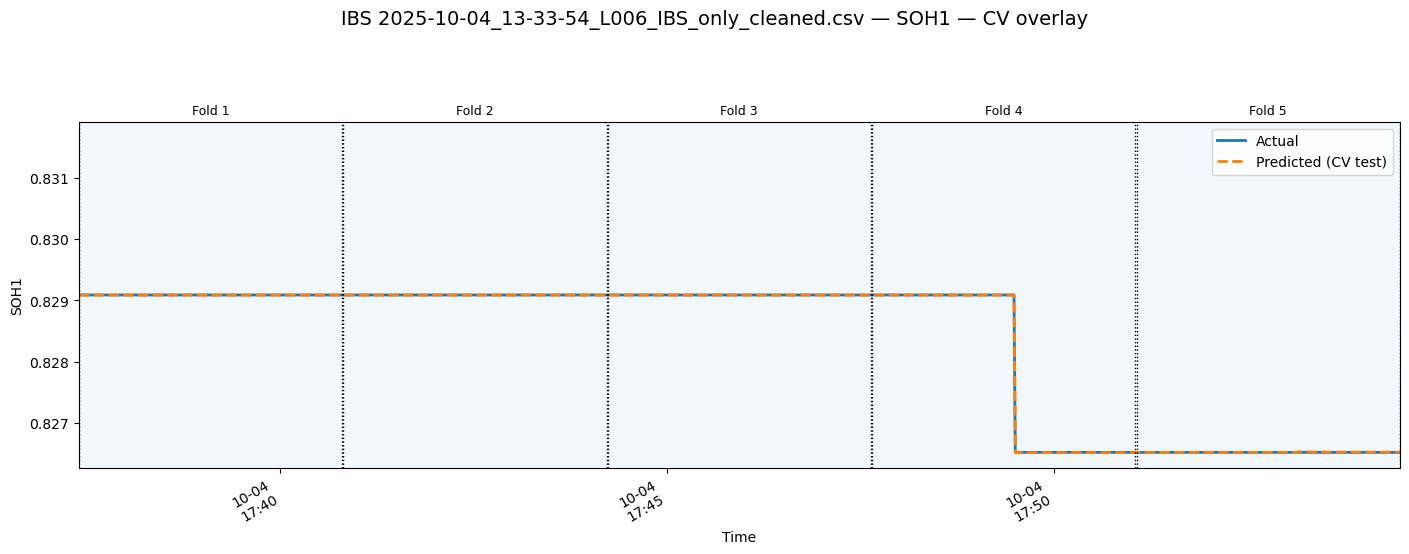

,fold,best_model,rmse,r2,best_params,file,target,features
0,1,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,0.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
1,2,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,0.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
2,3,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,-76.137,"{'poly__degree': 1, 'reg__fit_intercept': True}",IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
3,4,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,1.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"
4,5,"Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)), ('scale', StandardScaler()), ('reg', LinearRegression())])",0.0000,0.000,"{'poly__degree': 1, 'reg__fit_intercept': True}",IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv,SOH1,"IBS_BatteryVoltage, IBS_BatteryCurrent, IBS_BatteryTemperature, IBS_StateOfCharge, IBS_AvgRi, IBS_NominalCapacity, IBS_AvailableCapacity, IBS_DischargeableAh"


In [ ]:
path = CLEANED_CSV_DIR / "IBS 2025-10-04_13-33-54_L006_IBS_only_cleaned.csv"

all_fold_tables = []  

# Load in cleaned CSV Log File
#df = load_cleaned_csv(path)
df = pd.read_csv(path)          # Simple read. Do not resample as vehicle has sleep modes
df = pd.read_csv(path)
print(df.shape)
print(df.info())

targets = ["IBS_StateOfHealth", "SOH1"]   # Pass 1 and Pass 2

for target_col in targets:

    # Set features to IBS_FEATURES
    X = df[IBS_FEATURES]    

    # Assign y to either IBS_StateOfHealth or cacluclate SOH1
    if target_col == 'SOH1':
        y = calculate_soh1(df,return_components=True, return_series=True, resample_s=1, return_vendor=False)
        y = y['SOH1']
    else: 
        y = df["IBS_StateOfHealth"]

    # Utilize time series split to divide up dataframe into both train and test while preserving chronology of the data
    tscv = TimeSeriesSplit(n_splits=5)
    splits = list(tscv.split(X, y))

    y_pred_full = pd.Series(index=y.index, dtype=float)
    
    fold_metrics = []
    test_spans = []

    for fold, (train_idx, test_idx) in enumerate(splits, start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        lr_grid_model = build_pipeline().fit(X_train, y_train)      
        y_pred = lr_grid_model.predict(X_test)

        # track each fold's test span for overlay plot
        ts = y.index[test_idx[0]]
        te = y.index[test_idx[-1]]
        test_spans.append((ts, te))

        # Keep track of best model for this fold
        best_model = lr_grid_model.best_estimator_
        y_pred = best_model.predict(X_test)

        # Keep track of test predictions aligned to the original time series data
        y_pred_full.iloc[test_idx] = y_pred

        # Keep track of metrics per fold
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2   = r2_score(y_test, y_pred)
        fold_metrics.append({"fold": fold, "best_model": best_model,"rmse": rmse, "r2": r2, "best_params": lr_grid_model.best_params_})
        
    # Single overlay plot: Actual (full) vs Predicted (test only) with fold indicators
    plot_all_folds_overlay(y, y_pred_full, test_spans, title=f"{path.name} — {target_col} — CV overlay")

    # show per-fold metrics table for this file+target
    fold_df = pd.DataFrame(fold_metrics)
    fold_df["file"] = path.name
    fold_df["target"] = target_col
    fold_df["features"] = ", ".join(used_feats)
    display(fold_df.style.format({"rmse":"{:.4f}", "r2":"{:.3f}"}))
    all_fold_tables.append(fold_df)

    